# Projektbeschreibung

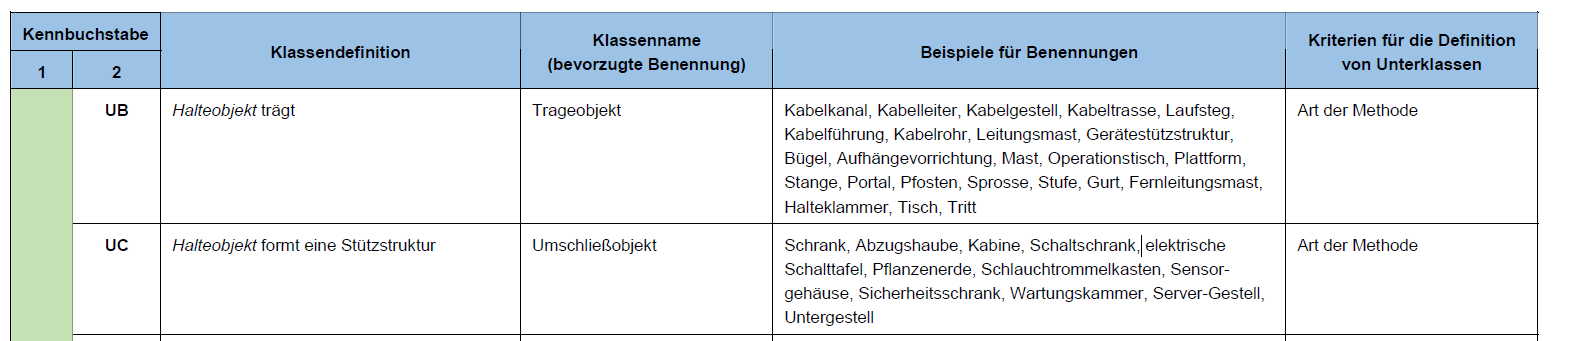

In grossen Bauprojekten ist es üblich eine Betriebsmittelbezeichnung zu vergeben. Diese dient dem Gebäudebetreiber unter anderem als Identifikator des Betriebmittels.

Hier ein Beispiel: 18.01.UC100.GB01 dies entspricht: 
[Gebäude Nr][Stockwerk][Anlage/System][Betriebsmittel]\
Wir konzentrieren uns auf die Kürzel der Anlage (UC) und des Betriebsmittel (GB). Diese Kürzel beschreiben die Funktion der Anlage/Betriebsmittel und werden aus einer Norm vergeben. In diesem Beispiel die "DIN EN IEC 81346-2", siehe ein Beispiel unten, dabei handelt es sich um ein PDF mit einer Tabelle welche der gesuchte Kennbuchstabe "UC" der Klassenamen "Umschliessobjekt" und ein paar Beispiele "Schrank, Abzugshaube, Kabine und Schaltschrank" dazu hat. 
In der Praxis hat der Planer die Aufgabe alle seine Betriebsmittel korrekt zu bezeichnen, dazu öffnet er die DIN-Norm(PDF) und sucht darin nach dem Betriesmittel z.B. Schaltschrank. Findet er diesen liest er das passende Kürzel aus und trägt es in die Betriebsmittelliste. Diese dient später dazu bei die Betriebsmittel eindeutig zu identifizieren. In einem mittelgrossen Projekt sprechen wir von 5k - 10k Betriebsmittel die benannt werden. 

Die Schwierigkeit dabei ist, dass man über die übliche Suchfunktion im Dokument nach einer passenden Klasse suchen mus um diese zu. Dies bedingt das der Suchbegriff in der Liste enthalten ist oder ein ändlicher. Dies ist in der Praxis sehr Zeitintensiv. Nun soll das vereinfacht werden in dem diese Abfrage über ein NLP Projekt erfolgt.

**Ziel:**
Es soll ein Modell trainiert werden welches anhand einer Benennung das dazu passende Kürzel vorschlägt. z.B. Bennenung "Schaltschrank" -> Kürzel "UC"

## Datenquellen

Als Datenquellen habe ich drei Dokumente gefunden welche Daten zu dem oben genanten Problem enthalten:

- DIN_EN_IEC_81346-2.pdf <- Europäische Norm Industrielle Anlagen
- DIN_6779-12.pdf <- Kennzeichungngssystematik für technische Produkte. Wurde aus der EN_81346-2 abgeleitet für Technische Gebäudeausrüstung.
- 20220207 Liste Funktionen_Komponenten_Signal.xlsx <- Arbeitsdokument aus einem Projekt in welchem die EN_81346-2 verwendet wurde.

# Aufbereitung

**DIN_EN_IEC_81346-2.pdf und DIN_6779-12.pdf**

In einem ersten Schritt habe ich die Daten aus den beiden PDF extrahiert. Dazu habe ich den PowerQuerry Editor von Excel verwendet. Dieser ermöglicht es die Tabellen welche in einem PDF enthalten sind auszulesen:

Hier ein Beispiel wie der Code aussehen kann:



```
let
    Quelle = Pdf.Tables(File.Contents("C:\Users\roman\OneDrive\Dokumente\01 FHNW\24_NLP Advanced\NLP-Case\data\raw\DIN_EN_IEC_81346-2.pdf"), [Implementation="1.3"]),
    Table015 = Quelle{[Id="Table015"]}[Data],
    #"Höher gestufte Header" = Table.PromoteHeaders(Table015, [PromoteAllScalars=true]),
    #"Geänderter Typ" = Table.TransformColumnTypes(#"Höher gestufte Header",{{"Column1", Int64.Type}, {"Kennbuchstabe", type text}, {"Column3", type text}, {"Column4", type text}, {"Column5", type text}, {"Column6", type text}}),
    #"Umbenannte Spalten" = Table.RenameColumns(#"Geänderter Typ",{{"Column3", "Klassendefinition"}, {"Column4", "Klassenname"}, {"Column5", "Beispiel"}}),
    #"Entfernte oberste Zeilen" = Table.Skip(#"Umbenannte Spalten",1),
    #"Umbenannte Spalten1" = Table.RenameColumns(#"Entfernte oberste Zeilen",{{"Column1", "aa"}})
in
    #"Umbenannte Spalten1"
```



Das Ergebiss war eine Tabelle mit Einträgen die etwa wie folgt aussehen:

| Kennbuchstabe| Klassendefinition | Klassenname | Beispiel |
| :- | :- | :- | :- |
| BE | Erkennungsobjekt für Spannungsfeld | Spannungsfelderkennungsobjekt | Spannungsfelddetektror, Spannungsfeldsensort, Magnetfelddetektor |

Somit waren in "Kennbuchstabe" mein Label und in den anderen drei Felder meine Features. Da in Beispiel die einzelnen Wörter keine Satzlogik haben im Sinne das sie Zusammen einen Sinn ergeben habe ich sie mit der Funktion Text zu Spalte in getrennte Spalten aufgeteilt.
Das Ergebnis sind die Excel "./data/RawDataPart1.xlsx" für das "PDF DIN_EN_IEC_81346-2" und "./data/RawDataPart2.xlsx" für das PDF "DIN_6779-12.pdf".

**20220207 Liste Funktionen_Komponenten_Signal.xlsx**

Die erste Aufbereitung der Liste aus dem Projekt war deutlich einfacher, da die Daten bereits in einer Liste sind. 

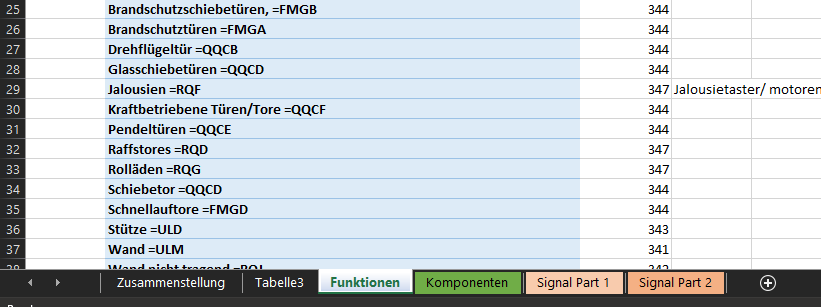

Im Originaldokument habe ich die Tabellen aus "Funktion" und "Komponente" Zusammengefasst und etwas bereinigt (löschen der leeren Zellen) in das Excelfile "./data/RawDataPart3.xlsx" übernommen.

# Preprocessing

Die drei Dateien "./data/RawDataPart1 - 3.xlsx" enthalten Label und Features in unterschiedlichen Spalten. Im folgenden Teil wird jeder Feature Spalte das passende Label zugewiesen. Mit dem Zeil am Ende eine Tabelle mit zwei Kollonen zu haben "Label und Feature".

In [9]:
# library imports
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

**Preprocessing - DIN_EN_IEC_81346-2.pdf**

In [12]:
dfraw = pd.read_excel('drive/MyDrive/Colab Notebooks NLP/data/RawDataPart1.xlsx')
dfraw.shape

(1125, 66)

In [13]:
dfraw.head(5)

,Kennbuchstabe,Klassendefinition,Klassenname,Beispiel,Spalte1,Spalte2,Spalte3,Spalte4,Spalte5,Spalte6,...,Spalte53,Spalte54,Spalte55,Spalte56,Spalte57,Spalte58,Spalte59,Spalte60,Spalte61,Spalte62
0,B,Objekt zur Erfassung und Darstellung von\nInfo...,Erkennungsobjekt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BA,Erkennungsobjekt für elektrisches Potential,Objekt zur Erkennung von\nelektrischem Potential,Kopplungskondensator,Messspannungsrelais,Spannungswandler für Messzwecke,Spannungsrelais,Spannungswandler,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BB,Erkennungsobjekt für Widerstand oder\nLeitfähi...,Objekt zur Erkennung von\nWiderstand,Detektor für elektrischen Widerstand,Sensor für elektrischenWiderstand,Detektor für thermischen Widerstand,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BC,Erkennungsobjekt für elektrischen Strom,Objekt zur Erkennung von\nelektrischem Strom,elektronisches Überlastrelais,Messstromrelais,Stromwandler fürMesszwecke,Überlastrelais,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BD,Erkennungsobjekt für Dichte,Dichteerkennungsobjekt,Senkwage,Dichtesensor,Dichteschalter,Dichtewandler,Hydrometer,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = pd.DataFrame(columns={"Kennzeichen","Beispiel"})

In [15]:
%%capture output
for row in range(len(dfraw)):
    for column in range(len(dfraw.columns)-1):
        if type(dfraw.loc[row][column+1]) == str:
            new_row = {'Kennzeichen': dfraw.loc[row][0], 'Beispiel' : dfraw.loc[row][column+1]}
            df = df.append(new_row, ignore_index=True)

In [16]:
df.head(5)

,Beispiel,Kennzeichen
0,Objekt zur Erfassung und Darstellung von\nInfo...,B
1,Erkennungsobjekt,B
2,Erkennungsobjekt für elektrisches Potential,BA
3,Objekt zur Erkennung von\nelektrischem Potential,BA
4,Kopplungskondensator,BA


In [24]:
#######################################
# Export to CSV
#######################################
from pathlib import Path
file_name = "drive/MyDrive/Colab Notebooks NLP/data/Part1_Prep.csv"
file_path = (Path().resolve() / file_name).as_posix()
df.to_csv(file_path, index=False)

**Preprocessing - DIN_6779-12.pdf**

In [18]:
dfraw2 = pd.read_excel('drive/MyDrive/Colab Notebooks NLP/data/RawDataPart2.xlsx')
dfraw2.shape

(172, 10)

In [19]:
dfraw2.head(5)

,Kennbuchstabe,Klassendefinition,Beispiel,Spalte1,Spalte2,Spalte3,Spalte4,Spalte5,Spalte6,Spalte7
0,BA,elektrisches Potential,Spannungswandler,Spannungsmesseinheit,Messwandler (Spannung),NaN,NaN,NaN,NaN,NaN
1,BC,elektrischer Strom,Messwandler (Strom),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BD,Dichte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BE,andere elektrische und elektromagnetische Größen,Messwandler,Messwiderstand,NaN,NaN,NaN,NaN,NaN,NaN
4,BF,"Fluss (Durchfluss, Durchsatz)",Volumenstrommessung,Messblende,Gaszähler,Wasserzähler,Durchflussmesser,NaN,NaN,NaN


In [20]:
df2 = pd.DataFrame(columns={"Kennzeichen","Beispiel"})

In [21]:
%%capture output
for row in range(len(dfraw2)):
    for column in range(len(dfraw2.columns)-1):
        if type(dfraw2.loc[row][column+1]) == str:
            new_row = {'Kennzeichen': dfraw2.loc[row][0], 'Beispiel' : dfraw2.loc[row][column+1]}
            df2 = df2.append(new_row, ignore_index=True)

In [22]:
df2

,Beispiel,Kennzeichen
0,elektrisches Potential,BA
1,Spannungswandler,BA
2,Spannungsmesseinheit,BA
3,Messwandler (Spannung),BA
4,elektrischer Strom,BC
...,...,...
598,Klebeverbindung,XQ
599,"Verbinden von Objekten, lösbar",XR
600,Haken,XR
601,Öse,XR


In [25]:
#######################################
# Export to CSV
#######################################
from pathlib import Path
file_name = "drive/MyDrive/Colab Notebooks NLP/data/Part2_Prep.csv"
file_path = (Path().resolve() / file_name).as_posix()
df2.to_csv(file_path, index=False)

**Preprocessing - 220220207 Liste Funktionenn_Komponenten_Signal.xlsx**

In [27]:
dfraw3 = pd.read_excel('drive/MyDrive/Colab Notebooks NLP/data/RawDataPart3.xlsx')
dfraw3.shape

(459, 2)

In [28]:
dfraw3.head(5)

,Kürzel,Beispiel
0,QQB,Fassade
1,QQA,Fenster
2,RQF,Jalousien
3,RQE,Markisen
4,FMB,Natürliche Rauchabzugsanlagen


In [29]:
df3 = pd.DataFrame(columns={"Kennzeichen","Beispiel"})

In [30]:
%%capture output
for row in range(len(dfraw3)):
    for column in range(len(dfraw3.columns)-1):
        if type(dfraw3.loc[row][column+1]) == str:
            new_row = {'Kennzeichen': dfraw3.loc[row][0], 'Beispiel' : dfraw3.loc[row][column+1]}
            df3 = df3.append(new_row, ignore_index=True)

In [31]:
df3.head(3)

,Beispiel,Kennzeichen
0,Fassade,QQB
1,Fenster,QQA
2,Jalousien,RQF


In [39]:
#######################################
# Export to CSV
#######################################
from pathlib import Path
file_name = "drive/MyDrive/Colab Notebooks NLP/data/Part3_Prep.csv"
file_path = (Path().resolve() / file_name).as_posix()
df3.to_csv(file_path, index=False)

**Zusammenzug aller Quellen**

In [32]:
df4 = pd.DataFrame(columns={"Kennzeichen","Beispiel"})

In [33]:
df4 =  df.append(df2, ignore_index=True)

In [34]:
df4 = df4.append(df3, ignore_index=True)

In [36]:
# delete empty entrys
df4.dropna(inplace=True)

In [37]:
df5 = df4[df4["Kennzeichen"].apply(lambda x: len(x) >= 1)]

In [38]:
df5.shape

(5910, 2)

In [40]:
#######################################
# Export to CSV
#######################################
from pathlib import Path
file_name = "drive/MyDrive/Colab Notebooks NLP/data/Total_Prep.csv"
file_path = (Path().resolve() / file_name).as_posix()
df5.to_csv(file_path, index=False)